<a href="https://colab.research.google.com/github/nakul-c/PM10_prediction_SciML/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from keras.models import Sequential, Model
from keras.layers import LSTM, Bidirectional, Dense, Dropout, Attention, Input, Add,Concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
# Load the data
file_path = '/content/drive/MyDrive/SciML/csvfiles/BIDHANAAGAR_complete_raw_data.csv'
data = pd.read_csv(file_path)
data.head()

,Timestamp,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),...,MP-Xylene (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),RF (mm),TOT-RF (mm),SR (W/mt2),BP (mmHg),VWS (m/s)
0,21-08-2019 00:00,11.24,43.98,NaN,NaN,0.00,9.30,6.10,0.25,15.18,...,1.96,30.25,79.99,0.47,243.74,0.00,0.0,47.24,997.75,-0.01
1,22-08-2019 00:00,21.28,45.70,4.19,83.86,1.65,5.42,8.01,0.18,36.86,...,0.82,29.28,85.10,0.33,181.71,0.08,7.2,147.78,997.21,-0.01
2,23-08-2019 00:00,7.80,19.51,4.46,NaN,4.46,NaN,2.12,0.20,43.98,...,1.21,28.81,86.44,0.35,154.85,0.01,1.4,168.01,997.27,-0.01
3,24-08-2019 00:00,7.48,19.47,13.18,277.32,7.74,232.41,2.93,0.18,40.97,...,0.81,27.42,94.65,0.35,121.75,0.01,1.2,177.57,997.04,-0.01
4,25-08-2019 00:00,7.10,16.46,32.36,33.16,46.91,38.57,1.47,0.18,62.44,...,0.56,27.42,93.10,0.80,117.91,0.00,0.0,230.91,999.25,-0.01


In [ ]:
# Convert columns to numeric
cols_to_convert = [
    'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)', 'NO2 (µg/m³)',
    'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
    'Ozone (µg/m³)', 'Benzene (µg/m³)', 'Toluene (µg/m³)',
    'Xylene (µg/m³)', 'O Xylene (µg/m³)', 'Eth-Benzene (µg/m³)',
    'MP-Xylene (µg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)',
    'WD (deg)', 'RF (mm)', 'TOT-RF (mm)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)'
]
for col in cols_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Convert timestamp to datetime and set as index
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M')
data.set_index('Timestamp', inplace=True)

# Handle missing values using KNN imputer
imputer = KNNImputer(n_neighbors=5)
data[cols_to_convert] = imputer.fit_transform(data[cols_to_convert])

# Feature Engineering: Adding lag features, rolling statistics, interaction features, and seasonal features
lags = [1, 3, 7]  # Lag by 1, 3, 7 days
for lag in lags:
    for col in cols_to_convert:
        data[f'{col}_lag{lag}'] = data[col].shift(lag)

# Adding rolling mean and std features
window_sizes = [3, 7, 14]  # Window sizes in days
for window in window_sizes:
    for col in cols_to_convert:
        data[f'{col}_rollmean{window}'] = data[col].rolling(window=window).mean()
        data[f'{col}_rollstd{window}'] = data[col].rolling(window=window).std()

# Adding interaction features
data['AT_RH'] = data['AT (°C)'] * data['RH (%)']
data['WS_WD'] = data['WS (m/s)'] * np.sin(data['WD (deg)'] * (np.pi / 180))
data['WS_WD_cos'] = data['WS (m/s)'] * np.cos(data['WD (deg)'] * (np.pi / 180))

# Adding seasonal features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Drop any remaining NaNs after lagging
data.dropna(inplace=True)

# Select features and target
features = [col for col in data.columns if col != 'PM10 (µg/m³)']
target = 'PM10 (µg/m³)'
data = data[features + [target]]

# Normalize the data
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data[features + [target]]), columns=features + [target])

# Display summary statistics
print(data_normalized.describe())

<ipython-input-8-ef602078c957>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_rollmean{window}'] = data[col].rolling(window=window).mean()
<ipython-input-8-ef602078c957>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_rollstd{window}'] = data[col].rolling(window=window).std()
<ipython-input-8-ef602078c957>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

       PM2.5 (µg/m³)   NO (µg/m³)  NO2 (µg/m³)    NOx (ppb)  NH3 (µg/m³)  \
count    1720.000000  1720.000000  1720.000000  1720.000000  1720.000000   
mean        0.221474     0.121961     0.209453     0.137437     0.081318   
std         0.176407     0.134333     0.167876     0.104746     0.052292   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.074709     0.048986     0.088598     0.066555     0.042216   
50%         0.164764     0.072385     0.168932     0.109440     0.069632   
75%         0.343849     0.136153     0.289246     0.174648     0.110311   
max         1.000000     1.000000     1.000000     1.000000     1.000000   

       SO2 (µg/m³)   CO (mg/m³)  Ozone (µg/m³)  Benzene (µg/m³)  \
count  1720.000000  1720.000000    1720.000000      1720.000000   
mean      0.146558     0.153433       0.209856         0.071622   
std       0.094388     0.104390       0.113409         0.068695   
min       0.000000     0.000000       0.000000 

In [ ]:
# Split the data into training, validation, and test sets
train_size = int(len(data_normalized) * 0.7)
valid_size = int(len(data_normalized) * 0.15)
train_data, valid_data, test_data = data_normalized[:train_size], data_normalized[train_size:train_size+valid_size], data_normalized[train_size+valid_size:]

# Function to create sequences
def create_sequences(data, target_col, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)].values)
        y.append(data[target_col].iloc[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Sequence length can be tuned
X_train, y_train = create_sequences(train_data, target, seq_length)
X_valid, y_valid = create_sequences(valid_data, target, seq_length)
X_test, y_test = create_sequences(test_data, target, seq_length)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)


(1194, 10, 246) (1194,) (248, 10, 246) (248,) (248, 10, 246) (248,)


# Model: LSTM-3

In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Define the LSTM model for tuning
def model_builder(hp):
    model = Sequential()

    # Tuning the number of units in LSTM layers
    lstm_units = hp.Int('units', min_value=50, max_value=200, step=50)
    model.add(LSTM(lstm_units, activation='relu', input_shape=(seq_length, X_train.shape[2]),
                   return_sequences=True, kernel_regularizer=l2(0.0001)))

    # Tune Dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Second LSTM layer with tunable units and dropout
    model.add(LSTM(lstm_units, activation='relu', return_sequences=False, kernel_regularizer=l2(0.0001)))
    model.add(Dropout(dropout_rate))

    # Dense layers
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))  # Output layer for PM10 prediction

    # Tune the learning rate for the Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return model

# Initialize the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparameter_tuning',
                     project_name='PM10_prediction')

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid),
             callbacks=[early_stopping, reduce_lr])

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM units: {best_hps.get('units')}")
print(f"Best Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)

# Train with early stopping and learning rate reduction
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the tuned model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Tuned Test Loss: {test_loss}")

# Predictions and evaluation metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test , y_pred)
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print(f"Tuned MAE: {mae}")
print(f"Tuned RMSE: {rmse}")
print(f"Tuned MSE: {mse}")
ss_res = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"Tuned R²: {r2}")

Trial 30 Complete [00h 00m 17s]
val_loss: 0.0409674309194088

Best val_loss So Far: 0.010195177979767323
Total elapsed time: 00h 07m 19s
Best LSTM units: 50
Best Dropout rate: 0.30000000000000004
Best learning rate: 0.01
Epoch 1/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - loss: 1.7144 - val_loss: 0.0371 - learning_rate: 0.0100
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0434 - val_loss: 0.0314 - learning_rate: 0.0100
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0399 - val_loss: 0.0291 - learning_rate: 0.0100
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0298 - val_loss: 0.0258 - learning_rate: 0.0100
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0305 - val_loss: 0.0252 - learning_rate: 0.0100
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0262 - val_loss: 0.0257 - learning_rate: 0.0100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0316 
Tuned Test Loss: 0.031215539202094078
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95m

y_pred: (248, 1) and X_test: (248, 10, 246)


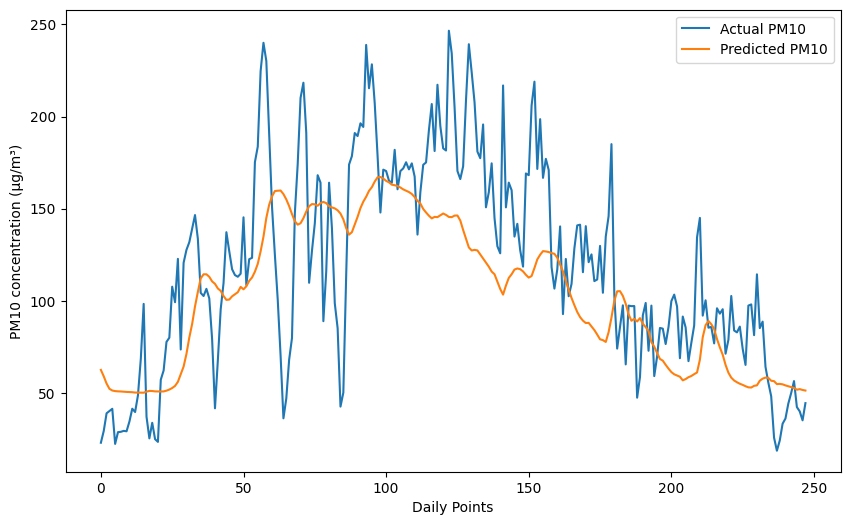

In [ ]:
print(f"y_pred: {y_pred.shape} and X_test: {X_test.shape}")
y_pred = scaler.inverse_transform(np.hstack((X_test[:, -1, :-1], y_pred)))[:, -1]  # inverse the scaling
y_test_actual = scaler.inverse_transform(np.hstack((X_test[:, -1, :-1], y_test.reshape(-1, 1))))[:, -1]
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual PM10')
plt.plot(y_pred, label='Predicted PM10')
plt.xlabel('Daily Points')
plt.ylabel('PM10 concentration (µg/m³)')
plt.legend()
plt.show()

y_pred: (248,) and y_test: (248,)


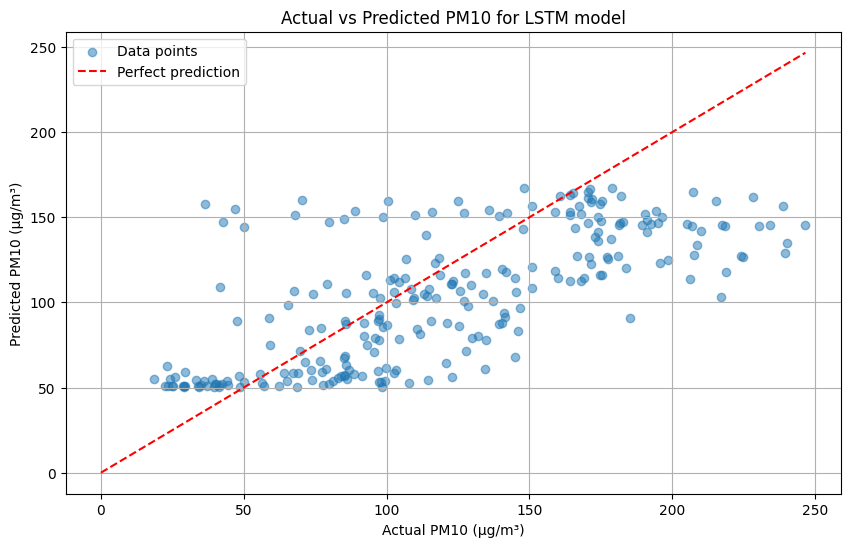

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are your actual and predicted values
# Convert tensors to numpy arrays if necessary
y_test_np = y_test_actual
test_predictions_np = y_pred
print(f"y_pred: {test_predictions_np.shape} and y_test: {y_test_np.shape}")
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Data points')

# Add a reference line (y=x)
max_val = max(y_test_np.max(), test_predictions_np.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect prediction')

# Add labels, legend, and title
plt.xlabel('Actual PM10 (µg/m³)')
plt.ylabel('Predicted PM10 (µg/m³)')
plt.title('Actual vs Predicted PM10 for LSTM model')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Model-3: GRU


In [ ]:
from tensorflow.keras.layers import GRU
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for PM10 prediction
model.compile(optimizer='adam', loss='mse')

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0380 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 10/100
38/38 ━━━━━━━━━

In [ ]:
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 
Test Loss: 0.02064785175025463


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


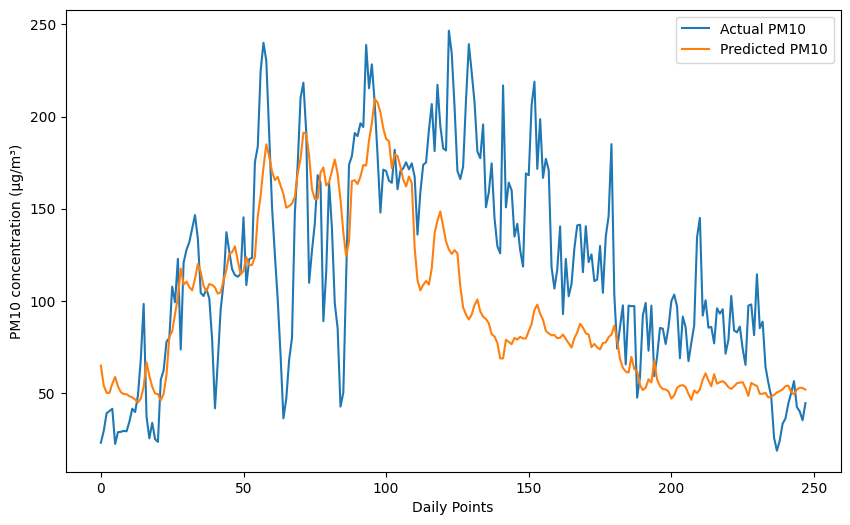

MAE: 39.56237832441094
RMSE: 50.413467090034956
MSE: 2541.5176640380373
Tuned R²: 0.19049232258546944


In [ ]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack((X_test[:, -1, :-1], y_pred)))[:, -1]  # Inverse scaling
y_test_actual = scaler.inverse_transform(np.hstack((X_test[:, -1, :-1], y_test.reshape(-1, 1))))[:, -1]
plt.figure(figsize=(10, 6))
plt.xlabel('Daily Points')
plt.ylabel('PM10 concentration (µg/m³)')
plt.plot(y_test_actual, label='Actual PM10')
plt.plot(y_pred, label='Predicted PM10')
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print("MAE:", mae)
print("RMSE:", rmse)
print("MSE:", mse)
ss_res = np.sum((y_test_actual - y_pred) ** 2)
ss_tot = np.sum((y_test_actual - np.mean(y_test_actual)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"Tuned R²: {r2}")

y_pred: (248,) and y_test: (248,)


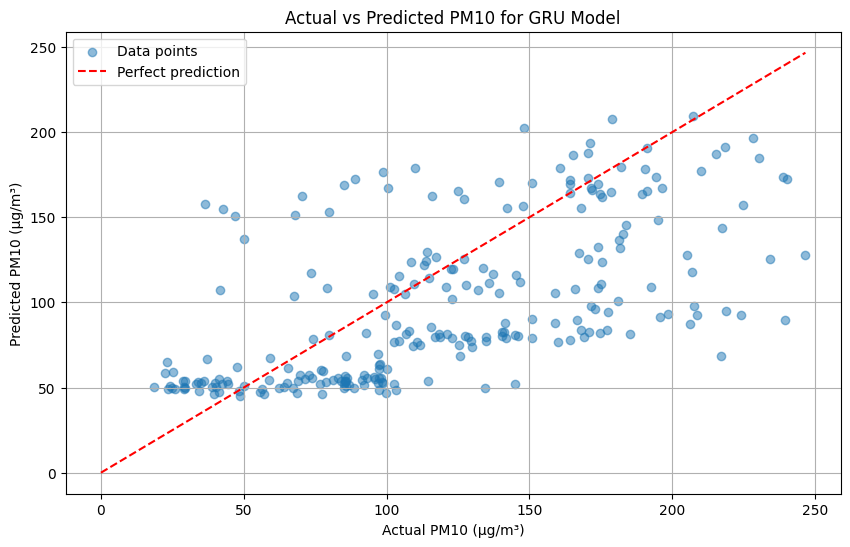

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are your actual and predicted values
# Convert tensors to numpy arrays if necessary
y_test_np = y_test_actual
test_predictions_np = y_pred
print(f"y_pred: {test_predictions_np.shape} and y_test: {y_test_np.shape}")
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Data points')

# Add a reference line (y=x)
max_val = max(y_test_np.max(), test_predictions_np.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect prediction')

# Add labels, legend, and title
plt.xlabel('Actual PM10 (µg/m³)')
plt.ylabel('Predicted PM10 (µg/m³)')
plt.title('Actual vs Predicted PM10 for GRU Model')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Model-5: GRU-3

In [ ]:
from keras.layers import Input, Dense, GRU, Bidirectional, Attention
from keras.models import Model
input_layer = Input(shape=(seq_length, X_train.shape[2]))
gru_output = Bidirectional(GRU(128, return_sequences=True, activation='relu'))(input_layer)
attention_output = Attention()([gru_output, gru_output])
gru_output = GRU(64, return_sequences=False, activation='relu')(attention_output)
dense_output = Dense(32, activation='relu')(gru_output)
final_output = Dense(1)(dense_output)

model = Model(inputs=input_layer, outputs=final_output)
model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 0.0219 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0102 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 10/100
75/7

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step


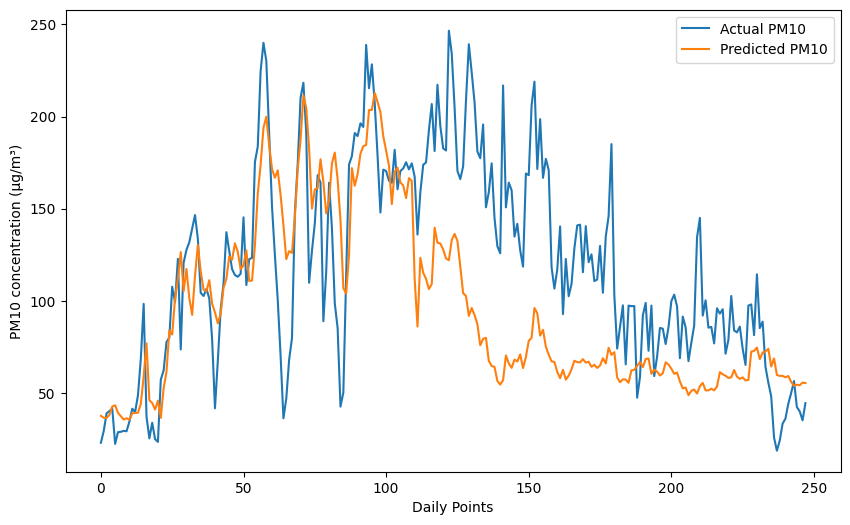

In [ ]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack((X_test[:, -1, :-1], y_pred)))[:, -1]  # Inverse scaling
y_test_actual = scaler.inverse_transform(np.hstack((X_test[:, -1, :-1], y_test.reshape(-1, 1))))[:, -1]

# Plot actual vs predicted PM10 values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual PM10')
plt.plot(y_pred, label='Predicted PM10')
plt.xlabel('Daily Points')
plt.ylabel('PM10 concentration (µg/m³)')
plt.legend()
plt.show()


y_pred: (248,) and y_test: (248,)


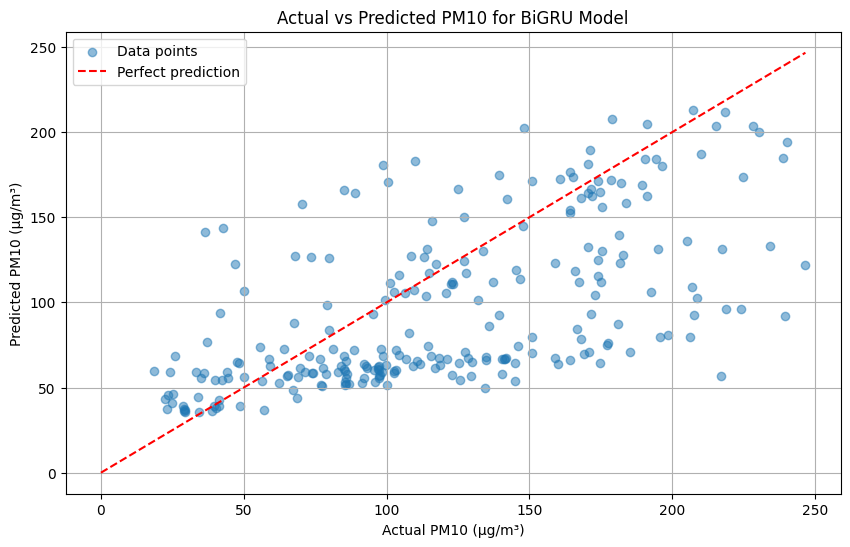

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are your actual and predicted values
# Convert tensors to numpy arrays if necessary
y_test_np = y_test_actual
test_predictions_np = y_pred
print(f"y_pred: {test_predictions_np.shape} and y_test: {y_test_np.shape}")
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, test_predictions_np, alpha=0.5, label='Data points')

# Add a reference line (y=x)
max_val = max(y_test_np.max(), test_predictions_np.max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect prediction')

# Add labels, legend, and title
plt.xlabel('Actual PM10 (µg/m³)')
plt.ylabel('Predicted PM10 (µg/m³)')
plt.title('Actual vs Predicted PM10 for BiGRU Model')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
# Assuming y_test is your actual values and y_pred is your predicted values
ss_res = np.sum((y_test_actual - y_pred) ** 2)
ss_tot = np.sum((y_test_actual - np.mean(y_test_actual)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print("MSE:", mse)
print(f"Tuned R²: {r2}")
print("MAE:", mae)
print("RMSE:", rmse)

MSE: 2675.523731147875
Tuned R²: 0.14780958160731472
MAE: 39.69842762957253
RMSE: 51.725465016255534


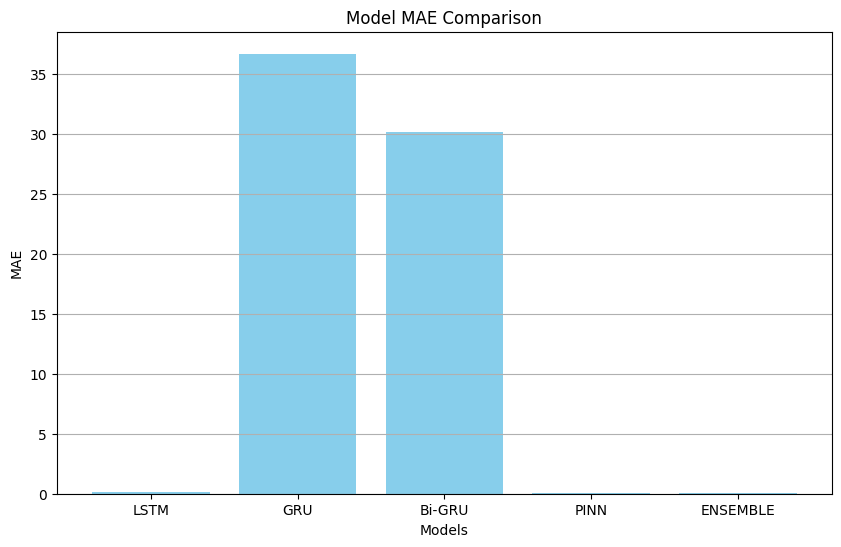

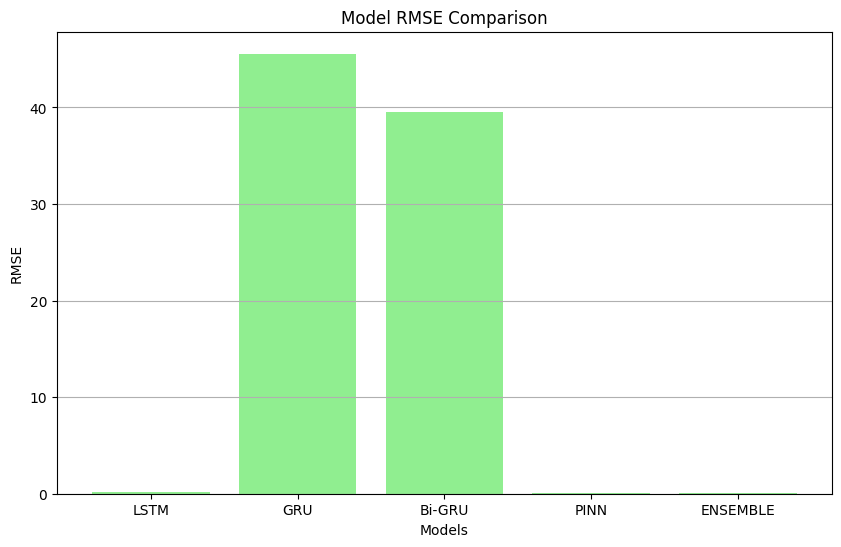

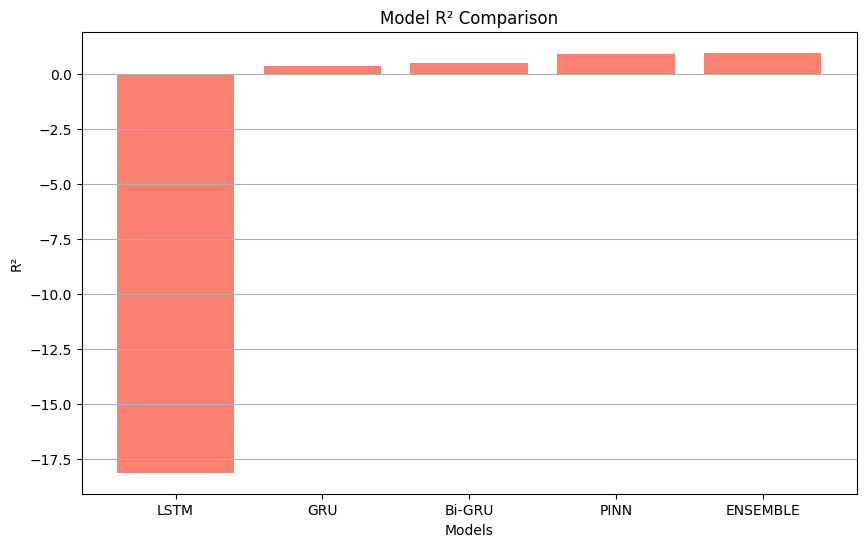

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the performance metrics for each model
models = ['LSTM', 'GRU', 'Bi-GRU', 'PINN', 'ENSEMBLE']
mae_values = [0.16027415450364849, 36.700385555160764, 30.198633972455163, 0.05509304627776146, 0.034957659378629886]
rmse_values = [0.16487302182218763, 45.56053287480848, 39.514803172768474, 0.06256622292943738, 0.04229863099768371]
r2_values = [-18.11679099873303, 0.33884173798485206, 0.5026667615810103, 0.8910850286483765, 0.9502193710178928]

# Plot MAE
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color='skyblue')
plt.title('Model MAE Comparison')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.grid(axis='y')
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color='lightgreen')
plt.title('Model RMSE Comparison')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()

# Plot R²
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='salmon')
plt.title('Model R² Comparison')
plt.xlabel('Models')
plt.ylabel('R²')
plt.grid(axis='y')
plt.show()
